**Vaibhav Singh 18303 Object Segmentation** **

***Step 1: Download and prepare the data***

In [2]:
# All the imports:
from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2DTranspose, add as keras_add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [4]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = 'images'
PATH_TO_CLASS_LIST = 'annotations/list.txt'
PATH_TO_XML_ANNOTATIONS = 'annotations/xmls'
PATH_TO_TRIMAPS = 'annotations/trimaps'

# Change if you wish. 
TARGET_SIZE = (128, 128)

In [5]:
# This should look familiar by now. We removed the bounding box specific stuff.
# We will be using this process on BOTH the input images and the trimaps.
def resize_image(path_to_image, target_size=None, pad_with_value=0):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad), pad_with_value)
    
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

    # This is a change, this function now handles data with either 1 or 3 color 
    # channels. We can detect this from the shape of the np.array so we've broken
    # this line into 3. 
    image_as_array = np.array(image.getdata())
    if len(image_as_array.shape) == 2:
        # This is required to handle transparency, which some of the JPGs contain.
        # We are essentially removing the alpha channel. 
        if image_as_array.shape[1] == 4:
            image_as_array = image_as_array[:, 0:3]
        image_data = image_as_array.reshape(image.size[0], image.size[1], 3)
    else:
        image_data = image_as_array.reshape(image.size[0], image.size[1])
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function.     
    return image_data

In [6]:
# Given a reshaped trimap, reduce it such that it contains
# 2 values: 0 for "not object of interest" and 1 for "object of interest"

# Note that, this transform includes the "unclassified" border zone
# as part of the background. If you wanted to explicitly classify
# the border seprately from the image you'd have to make this transform
# more involved, and not reduce the trimap to jsut values. 

# Similarly, if you had examples with dogs and cats in the same image
# This reduction step would have to account for those values differently
def reduce_trimap_values(trimap):
    return np.where((trimap == 1), 1, 0)

In [7]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well the reshaped trimap
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_trimap = os.path.join(PATH_TO_TRIMAPS, sample_name + '.png')

    image_data = resize_image(path_to_image, TARGET_SIZE)
    
    # Note that in OUR TRIMAPS 1 is the value for "background"
    # The final value of 2 is specific to our dataset!!
    trimap = resize_image(path_to_trimap, TARGET_SIZE, 2) 
    
    return (image_data, trimap)

In [8]:
# Plot just the image, or just the trimap, by leaving them none. 
# If both are specified the trimap will be printed on top of the image
# in a semi-transparent way. I love how easy this one is. 
def plot_with_trimap_overlay(image=None, trimap=None):
    if image is not None:
        plt.imshow(image)
    
    if trimap is not None:
        plt.imshow(trimap, alpha=.5)
    
    plt.colorbar()
    plt.show()
    

(128, 128, 3) (128, 128)


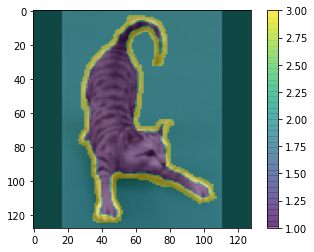

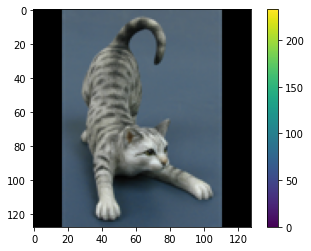

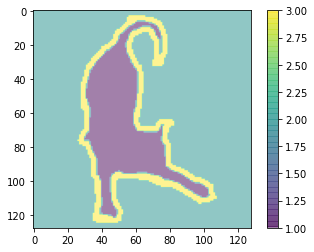

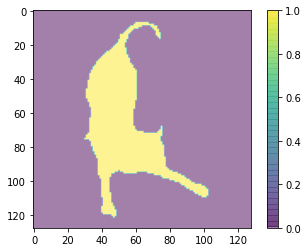

In [9]:
# Lets test out our functions
sample_name = 'Egyptian_Mau_14'
image, trimap = prepare_sample_from_name(sample_name)

print(image.shape, trimap.shape)

plot_with_trimap_overlay(image, trimap)
plot_with_trimap_overlay(image=image)
plot_with_trimap_overlay(trimap=trimap)
plot_with_trimap_overlay(trimap=reduce_trimap_values(trimap))

In [10]:
# Okay, lets get all our samples processed. After this we'll prepare the 
# data and labels for our network and perform a validation split.
processed_data = []

# Processing all this data takes some time... 
# Took my laptop roughly 8 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, trimap = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # More images have their trimap than had their bounding box
            # which is a small surprise.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(species) - 1, trimap)
        processed_data.append(data_tuple)
        
print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data)

Processed 7349 samples


5585 dog


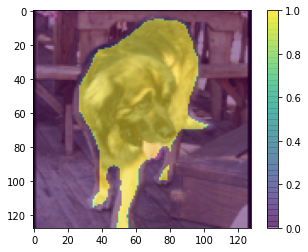

6303 cat


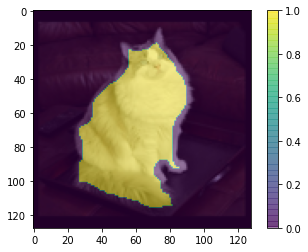

1982 dog


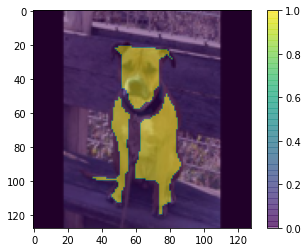

3126 dog


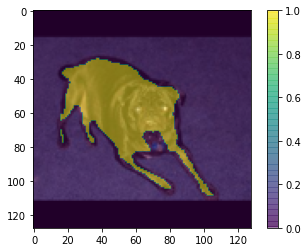

6695 dog


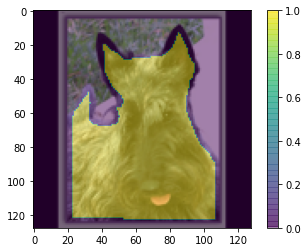

In [11]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, trimap = processed_data[i]
    
    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_trimap_overlay(image, reduce_trimap_values(trimap))

In [12]:
# This time around, instead of training two outputs on a single network
# we're going to have the final output layer produce 3 activation maps
# One activation map each for the location of cats, dogs, and background

# In our dataset, for the true labels, one of these panes will always
# be empty (all 0), because our dataset never has images with a cat and 
# a dog in the same image. 

# We'll test our network afterwards on a few images with both
# dogs and cats, and see what happens... cross your fingers, but don't hold your breath!
x_train = []
y_train = []

x_validation = []
y_validation = []

validation_split = 0.2

# Notice that we're applying the preprocess_input function to the images here.
# Also note that our labels are shaped (w, h, 3), one pane each for "cat, dog, background"
for image, species, trimap in processed_data:
    processed_image = preprocess_input(image)
    
    # 3 panes each with binary values. Note they mutually exclusive, each pixel can be "on"
    # in exactly ONE of the three following maps.
    cat_segmentation = reduce_trimap_values(trimap) if species == 0 else np.zeros(trimap.shape)
    dog_segmentation = reduce_trimap_values(trimap) if species == 1 else np.zeros(trimap.shape)
    bg_segmentation = np.logical_not(reduce_trimap_values(trimap))
    
    if np.random.random() > validation_split:
        x_train.append(processed_image)
        y_train.append([cat_segmentation, dog_segmentation, bg_segmentation])
    else:
        x_validation.append(processed_image)
        y_validation.append([cat_segmentation, dog_segmentation, bg_segmentation])
        
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

# Because of how we appeneded the cat and dog data to the labels
# we need to change the dimensions before prediction so that the
# color channels are where the network expects them:
y_train = np.rollaxis(y_train, 1, 4)
y_validation = np.rollaxis(y_validation, 1, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (128, 128, 3)


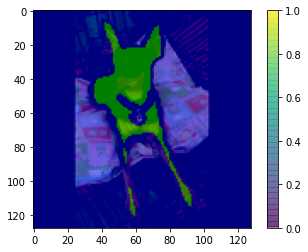

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (128, 128, 3)


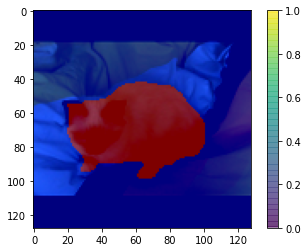

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (128, 128, 3)


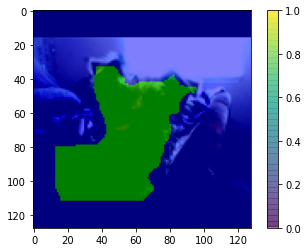

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (128, 128, 3)


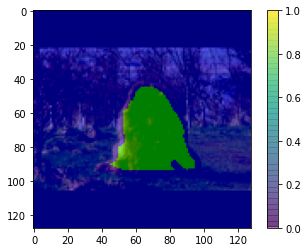

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (128, 128, 3)


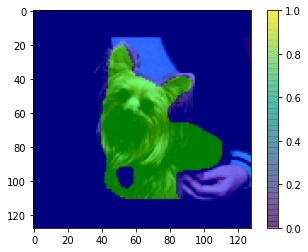

In [13]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(x_train))
    image = x_train[i]
    label = y_train[i]    
    
    # Note that it is coincidence that these are the same shape!!!
    # The image is 3 color channels, the label is 3 classes (cat, dog, background)
    # The result is R = cat, G = dog, B = background when using imshow
    print(image.shape, label.shape)
    plot_with_trimap_overlay(image, label)

 **Step 2: Build the model**



Part A: ***Mobile net*** (used in Reference Notebook)

In [ ]:
# We don't have a TON of data, but we could actually do some data augmentation
# Because the label data is in the same format as the input. We'd have to 
# transform the labels which is not built into Keras, but might be a good exercise
# for later... 

# Lets still use transfer learning
# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we have to use "Convolution Transpose" sometimes called "Deconvolution" to 
# re-increase the resolution, since MobileNetV2 significantly reduces the input size
# Drawing on inspiration from U-Net, we're also going to add some symmetric skip connections
# which should make us feel *very* fancy. 
segmentation_output = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(chopped_mobilenet.output)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[45].output])
)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[27].output])
)

# Note: we use 3 frames, one for cat one for dog one for background, and we 
# and likely improve our result, especially with respect to generalization and finding
# BOTH cats and dogs in the same image. Plus, it would allow us to detect the absense
# of either cats or dogs more readily. 
segmentation_output = Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='softmax')(segmentation_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[segmentation_output])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________________

**Step 3: Train and evaluate the model**

Part A:MobileNet

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# Warning, this takes forever. 
model.fit(x_train, y_train, 
          validation_data=(x_validation, y_validation),
          epochs=5,
          verbose=True
)

Epoch 1/5
185/185 [==============================] - 354s 2s/step - loss: 0.3389 - accuracy: 0.8566 - val_loss: 0.9364 - val_accuracy: 0.8278
Epoch 2/5
185/185 [==============================] - 351s 2s/step - loss: 0.2097 - accuracy: 0.9171 - val_loss: 0.9044 - val_accuracy: 0.8486
Epoch 3/5
185/185 [==============================] - 350s 2s/step - loss: 0.1518 - accuracy: 0.9415 - val_loss: 1.0024 - val_accuracy: 0.8438
Epoch 4/5
185/185 [==============================] - 353s 2s/step - loss: 0.1294 - accuracy: 0.9499 - val_loss: 0.9107 - val_accuracy: 0.8519
Epoch 5/5
185/185 [==============================] - 352s 2s/step - loss: 0.1189 - accuracy: 0.9531 - val_loss: 0.4263 - val_accuracy: 0.8895


In [ ]:
#import os
#model.save(os.path.join("saved_models", "segmentation_example.h5"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


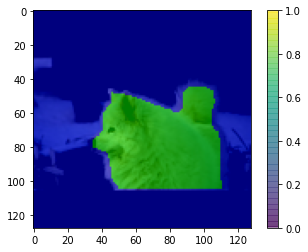

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


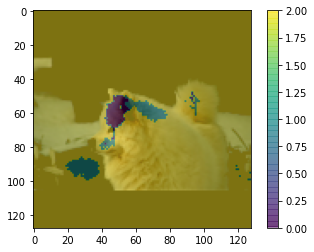

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


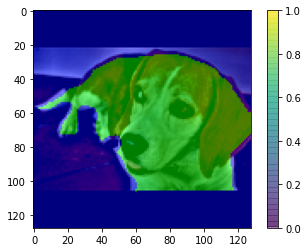

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


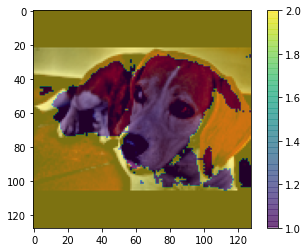

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


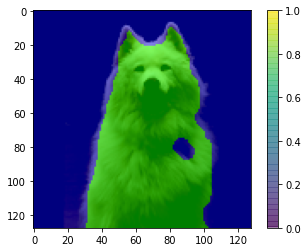

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


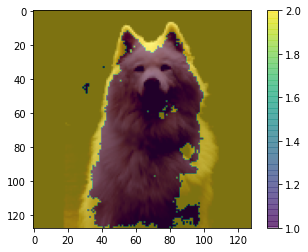

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


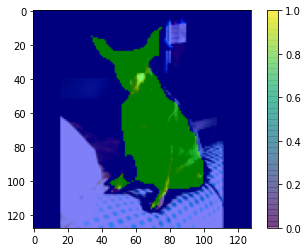

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


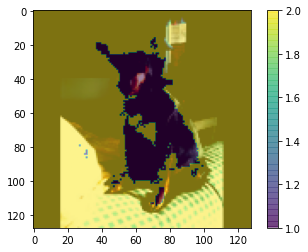

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


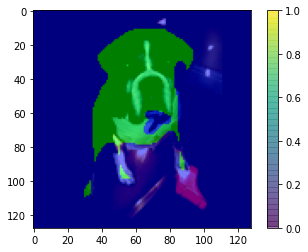

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


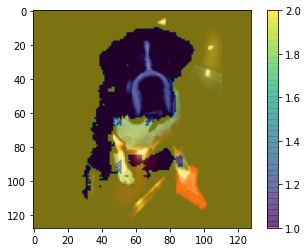

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


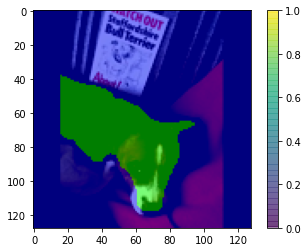

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


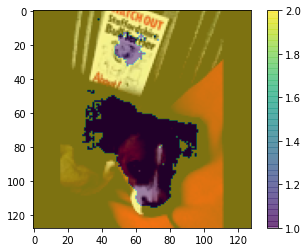

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


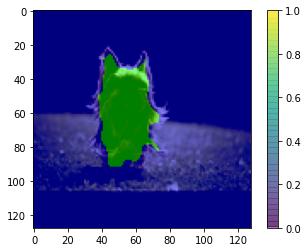

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


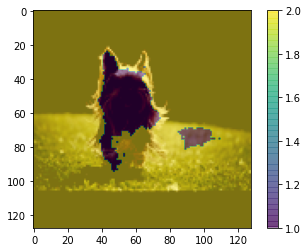

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


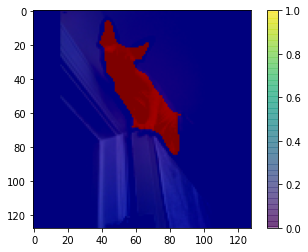

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


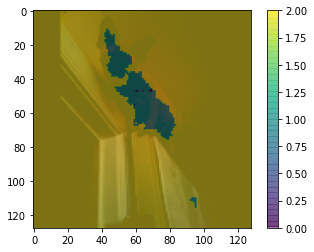

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


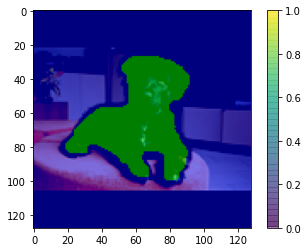

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


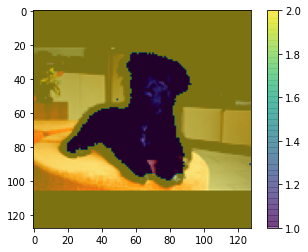

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


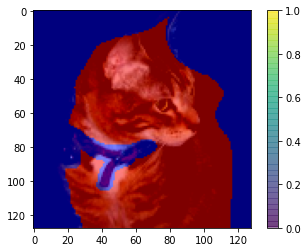

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


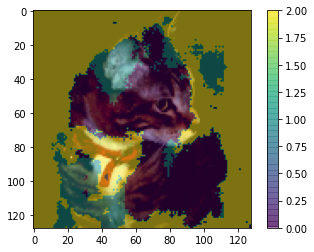

In [ ]:
for _ in range(10):
    i = np.random.randint(len(y_validation))
    img = x_validation[i]
    label = y_validation[i]
    pred = model.predict(np.array([img]))
    
    pred_panes = pred[0]
    pred_panes_maxed = np.argmax(pred_panes, axis=2)
    

    print("True Label")
    plot_with_trimap_overlay(img, label)
    
    print("Prediction")
    plot_with_trimap_overlay(img, pred_panes_maxed)

In [ ]:
!tar -xvf cats.tar

cats/cat1.png
cats/cat2.png
cats/cat3.png


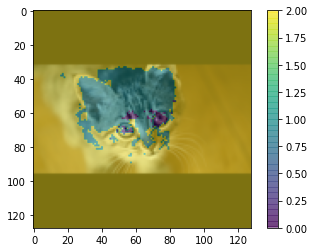

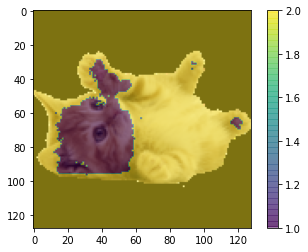

In [ ]:
# Lets see how it does on some random images from the internet...
# These are actually included in the repo.
photo_dir = 'cats'
photos = [
    'cat1.png',
    'cat3.png',
    
    
    
]

for photo in photos:
    photo_path = os.path.join(photo_dir, photo)
    resized_photo = resize_image(photo_path, TARGET_SIZE)
    processed_photo = preprocess_input(resized_photo)
    pred = model.predict(np.array([processed_photo]))
    
    pred_panes = pred[0]
    pred_panes_maxed = np.argmax(pred_panes, axis=2)
    plot_with_trimap_overlay(resized_photo, pred_panes_maxed)

**Step 2 : Build The Model**

Part 2 : **UNET Model** (We have chosen the unet model because it is more successful than conventional models, in terms of architecture and in terms pixel-based image segmentation formed from convolutional neural network layers. It’s even effective with limited dataset images. The most special aspect of the architecture in the second half. The network does not have a fully-connected layer. Only the convolution layers are used. Each standard convolution process is activated by a ReLU activation function)

In [14]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


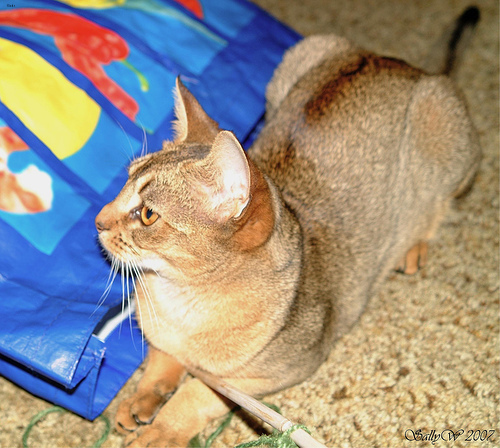

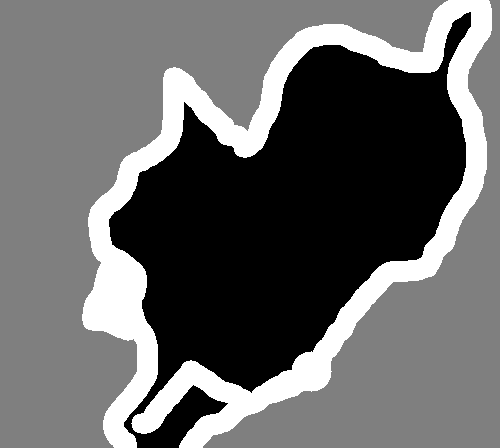

In [15]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)


In [16]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


In [17]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


**Step 3 : Train and evaluate the Model**

Part 2: Unet Architecture

We have taken the codes from keras website

In [19]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/5
199/199 [==============================] - 1688s 8s/step - loss: 1.0614 - val_loss: 2.1630
Epoch 2/5
199/199 [==============================] - 1688s 8s/step - loss: 0.5151 - val_loss: 2.6886
Epoch 3/5
199/199 [==============================] - 1701s 9s/step - loss: 0.4334 - val_loss: 0.4937
Epoch 4/5
199/199 [==============================] - 1706s 9s/step - loss: 0.3947 - val_loss: 0.4159
Epoch 5/5
199/199 [==============================] - 1706s 9s/step - loss: 0.3540 - val_loss: 0.4027


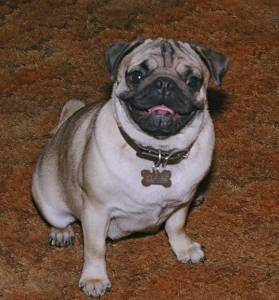

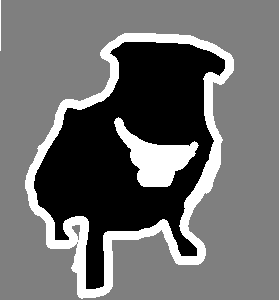

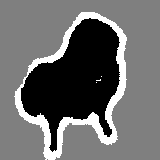

In [20]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


Thus we can easily conclude that unet architecture performs better object segmentation than mobilenet architecture but at more computational time and memory